In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib

# Reproducibility
RNG = 42
np.random.seed(RNG)

# Paths
ROOT = Path("..").resolve()
DATA_OUT = ROOT / "outputs"
FEAT_PATH = DATA_OUT / "features_melodies.csv"

print("Feature file:", FEAT_PATH)


Feature file: /home/satan/git/audio_analysis/outputs/features_melodies.csv


In [3]:
# Load features (one row per audio sample)
df = pd.read_csv(FEAT_PATH)

# Basic sanity check
print("Shape:", df.shape)
print("Columns:", len(df.columns))
print(df.head(2))

# Define feature groups (matching previous notebooks)
def split_groups(df: pd.DataFrame):
    temporal = ["rms", "attack_time_s", "onset_rate_s"]
    spectral = [c for c in df.columns if any(k in c for k in [
        "centroid_", "bandwidth_", "rolloff_", "flatness_", "flux_", "zcr_", "contrast_"
    ])]
    percept  = ["hnr_proxy_db"] + [c for c in df.columns if c.startswith("mfcc") or c.startswith("chroma")]
    meta = ["instrument", "file"]
    return temporal, spectral, percept, meta

temporal, spectral, percept, meta = split_groups(df)

# Target and feature columns
y = df["instrument"].copy()

# Keep only numeric feature columns and drop meta
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols_all = [c for c in (temporal + spectral + percept) if c in numeric_cols]

print(f"Temporal: {len([c for c in temporal if c in feature_cols_all])} | "
      f"Spectral: {len([c for c in spectral if c in feature_cols_all])} | "
      f"Perceptual: {len([c for c in percept if c in feature_cols_all])}")


Shape: (56, 66)
Columns: 66
  instrument              file  rms  attack_time_s  hnr_proxy_db  \
0       bass  Track10_Bass.wav  0.1       0.027574           NaN   
1       bass  Track11_Bass.wav  0.1       0.026485           NaN   

   tempo_est_bpm  onset_rate_s  centroid_mean  centroid_std  centroid_median  \
0      60.092660           3.0     128.833596     44.026555       123.676584   
1      80.749512           2.8     148.449733     67.313258       133.004247   

   ...  chroma2_mean  chroma3_mean  chroma4_mean  chroma5_mean  chroma6_mean  \
0  ...      0.711007      0.712428      0.610140      0.553844      0.526440   
1  ...      0.587893      0.699611      0.590596      0.510743      0.361813   

   chroma7_mean  chroma8_mean  chroma9_mean  chroma10_mean  chroma11_mean  
0      0.473120      0.369910      0.328208       0.340134       0.386644  
1      0.284497      0.221579      0.192535       0.161158       0.182380  

[2 rows x 66 columns]
Temporal: 3 | Spectral: 21 | Perce

In [4]:
# Replace inf with NaN so the imputer can handle them
X_all = df[feature_cols_all].replace([np.inf, -np.inf], np.nan).copy()

# Quick diagnostics (optional)
nan_per_col = X_all.isna().sum().sort_values(ascending=False)
print("Top NaN columns:\n", nan_per_col.head(10))

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=RNG, stratify=y
)

# Common preprocessing pipeline: impute (median) + standardize
preproc = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Fit only on train to avoid leakage, transform both
Xtr = preproc.fit_transform(X_train)
Xte = preproc.transform(X_test)

print("Train shape:", Xtr.shape, "| Test shape:", Xte.shape)


Top NaN columns:
 hnr_proxy_db        26
attack_time_s        0
rms                  0
centroid_mean        0
centroid_std         0
centroid_median      0
onset_rate_s         0
bandwidth_std        0
bandwidth_median     0
rolloff_mean         0
dtype: int64
Train shape: (44, 63) | Test shape: (12, 63)


In [5]:
def eval_subset(cols, model):
    """Impute + scale inside a pipeline for the selected columns, then fit & evaluate."""
    # Select subset from original frame
    Xsub = df[cols].replace([np.inf, -np.inf], np.nan)
    X_train, X_test, y_train, y_test = train_test_split(
        Xsub, y, test_size=0.2, random_state=RNG, stratify=y
    )
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", model),
    ])
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    f1  = f1_score(y_test, yhat, average="macro")
    return acc, f1, y_test, yhat, pipe


In [6]:
# Feature subsets
subsets = {
    "temporal": [c for c in temporal if c in feature_cols_all],
    "spectral": [c for c in spectral if c in feature_cols_all],
    "perceptual": [c for c in percept if c in feature_cols_all],
    "all": feature_cols_all
}

# Models to compare
models = {
    "kNN": KNeighborsClassifier(n_neighbors=5, metric="minkowski"),
    "SVM": SVC(kernel="rbf", C=10, gamma="scale"),
    "RF":  RandomForestClassifier(n_estimators=400, random_state=RNG)
}

# Evaluate
results = []
fitted = {}  # keep best pipeline per (subset, model)
for name_subset, cols in subsets.items():
    for name_model, clf in models.items():
        acc, f1, y_true, y_pred, pipe = eval_subset(cols, clf)
        results.append({"subset": name_subset, "model": name_model, "acc": acc, "f1": f1})
        fitted[(name_subset, name_model)] = (pipe, y_true, y_pred, cols)

res_df = pd.DataFrame(results).sort_values(["subset","f1"], ascending=[True, False])
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
res_df


,subset,model,acc,f1
9,all,kNN,1.000,1.000
10,all,SVM,1.000,1.000
11,all,RF,1.000,1.000
6,perceptual,kNN,1.000,1.000
7,perceptual,SVM,1.000,1.000
8,perceptual,RF,1.000,1.000
3,spectral,kNN,1.000,1.000
4,spectral,SVM,1.000,1.000
5,spectral,RF,1.000,1.000
1,temporal,SVM,0.583,0.586


Best: {'subset': 'spectral', 'model': 'kNN', 'acc': 1.0, 'f1': 1.0}

Classification report:
               precision    recall  f1-score   support

        bass       1.00      1.00      1.00         3
       flute       1.00      1.00      1.00         3
       piano       1.00      1.00      1.00         3
     trumpet       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



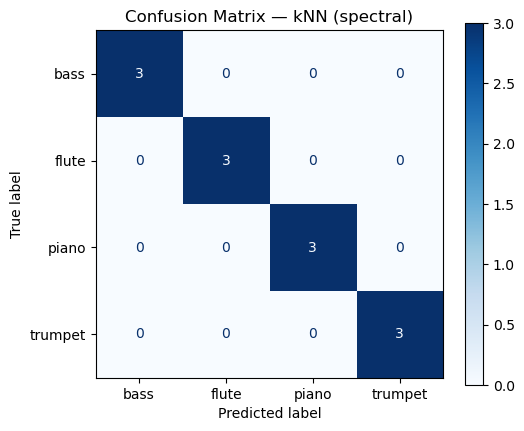

In [7]:
# Select the best by F1-macro
best = max(results, key=lambda r: r["f1"])
b_subset, b_model = best["subset"], best["model"]
pipe, y_true, y_pred, cols = fitted[(b_subset, b_model)]

print("Best:", best)
print("\nClassification report:\n", classification_report(y_true, y_pred))

# Confusion matrix
fig, ax = plt.subplots(figsize=(5.5, 4.5))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap="Blues")
ax.set_title(f"Confusion Matrix — {b_model} ({b_subset})")
plt.tight_layout()
plt.show()


In [8]:
# Cross-validate the best pipeline configuration more robustly
X_best = df[cols].replace([np.inf, -np.inf], np.nan)
y_all  = df["instrument"].copy()

cv_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", models[b_model]),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
acc_cv = cross_val_score(cv_pipe, X_best, y_all, scoring="accuracy", cv=cv)
f1_cv  = cross_val_score(cv_pipe, X_best, y_all, scoring="f1_macro", cv=cv)

print(f"5-fold CV — {b_model} ({b_subset}) | "
      f"ACC: {acc_cv.mean():.3f}±{acc_cv.std():.3f} | "
      f"F1: {f1_cv.mean():.3f}±{f1_cv.std():.3f}")


5-fold CV — kNN (spectral) | ACC: 0.964±0.045 | F1: 0.956±0.054


In [13]:
if b_model == "RF":
    # Refit RF on the train/test split used above to access feature importances
    # (They are not always stable; treat as qualitative insight.)
    rf = pipe.named_steps["clf"]
    importances = rf.feature_importances_
    imp = pd.Series(importances, index=cols).sort_values(ascending=False).head(20)
    print("Top-20 feature importances (RF):")
    display(imp)

    # Simple bar plot
    plt.figure(figsize=(6,4.5))
    imp.sort_values().plot(kind="barh")
    plt.title("Top Feature Importances — Random Forest")
    plt.tight_layout()
    plt.show()


In [11]:
# Save the best trained pipeline (imputer + scaler + model)
MODEL_DIR = DATA_OUT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODEL_DIR / f"best_{b_model}_{b_subset}.joblib"
joblib.dump(pipe, model_path)

print("Saved model:", model_path)
print("Num features in this model:", len(cols))


Saved model: /home/satan/git/audio_analysis/outputs/models/best_kNN_spectral.joblib
Num features in this model: 21


In [15]:
# Reutiliza exatamente o melhor pipeline e as predições já calculadas
pipe, y_true, y_pred, cols = fitted[(b_subset, b_model)]

preview = pd.DataFrame({
    "y_true": y_true.values,
    "y_pred": y_pred
}).head(10)

preview

,y_true,y_pred
0,bass,bass
1,flute,flute
2,flute,flute
3,flute,flute
4,trumpet,trumpet
5,piano,piano
6,bass,bass
7,piano,piano
8,trumpet,trumpet
9,trumpet,trumpet
